# Synchornization in complete networks of neurons
Here is the dynamics of neurons potentails in rotational model :
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) +  E \\
\ddot{E}+ 2\alpha \dot{E}+\alpha^{2}E =\frac{\alpha^{2}}{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
num_neurons = 1000
g =  5
random_input_span = (1.2,2.8) #it should fall in the well defined cos(\theta) domain.

total_time = 1000
time_step = 0.01
total_steps = int(total_time/time_step)
time_span = np.arange(0,total_time,time_step)

delay_time = 0.1
delay_step = int(delay_time/time_step)

alpha = 20
m_arr = np.zeros(total_steps)
e_arr = np.zeros(total_steps)

theta_arr = np.zeros(num_neurons,dtype = float)
# theta_arr = np.random.uniform(0,2*np.pi,size = num_neurons)
random_input = np.random.uniform(*random_input_span,size = num_neurons)

In [3]:
spiking_records = np.array( np.zeros((total_steps,num_neurons)), dtype = bool )
amin_saman_param = np.zeros( total_steps )

In [4]:
def retarded_spikes_record(step):
    """
    This is the function which take cares of response delay between spikes and their effects.
    """
    if step > delay_step: 
        return np.sum(spiking_records[step - delay_step])
    else:
        return 0


## "For" loop on the march!
To make equations more solvable we turn them into three cases of linear first order equations:
$$
\begin{cases}
\dot{\theta_i}=I_i - cos(\theta_i) - g E \\
\dot{E} = M - \alpha E\\
\dot{M} = -  \alpha M + \frac{ \alpha^{2} }{N} \sum_{n|tـn<t} \delta(t - t_n - t_d)
\end{cases}
$$

In [5]:
for i in tqdm( range(total_steps - 1) ):
    theta_arr = theta_arr + (random_input - np.cos(theta_arr) - g * e_arr[i] )*time_step
    
    #here we should spot the spiking neurons.
    spiking_records[i] = theta_arr > np.pi
    theta_arr = theta_arr - 2 * np.pi * spiking_records[i]
    
    m_arr[i+1] = m_arr[i] + time_step*( -alpha*m_arr[i] ) + ( (alpha**2)/num_neurons ) *retarded_spikes_record(i) 
    e_arr[i+1] = e_arr[i] + time_step*( m_arr[i] - alpha*e_arr[i] )
    
    amin_saman_param[i] = np.mean( np.sin(theta_arr) )**2
    

100%|█████████████████████████████████████████████████████████████████████████| 99999/99999 [00:06<00:00, 16632.30it/s]


(array([ 35.,  29.,  44., 204., 281., 178.,  90.,  66.,  43.,  30.]),
 array([-3.12904678e+00, -2.50370067e+00, -1.87835456e+00, -1.25300844e+00,
        -6.27662328e-01, -2.31621447e-03,  6.23029900e-01,  1.24837601e+00,
         1.87372213e+00,  2.49906824e+00,  3.12441436e+00]),
 <a list of 10 Patch objects>)

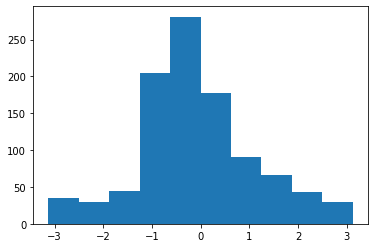

In [6]:
plt.hist(theta_arr)

In [7]:
sigma = np.std( e_arr )
sigma

0.030293958496175544

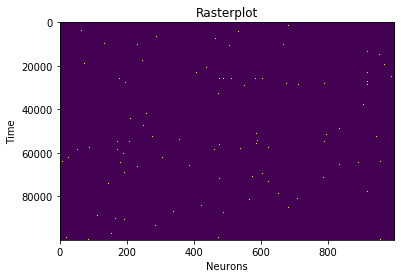

In [8]:
plt.imshow( spiking_records,aspect= 'auto')
plt.xlabel('Neurons')
plt.ylabel('Time')
plt.title('Rasterplot')
plt.savefig('raster_plot_N{}_g{}.png'.format(num_neurons,g))

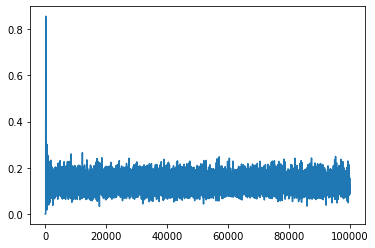

In [9]:
plt.plot(e_arr)

(array([ 35.,  29.,  44., 204., 281., 178.,  90.,  66.,  43.,  30.]),
 array([-3.12904678e+00, -2.50370067e+00, -1.87835456e+00, -1.25300844e+00,
        -6.27662328e-01, -2.31621447e-03,  6.23029900e-01,  1.24837601e+00,
         1.87372213e+00,  2.49906824e+00,  3.12441436e+00]),
 <a list of 10 Patch objects>)

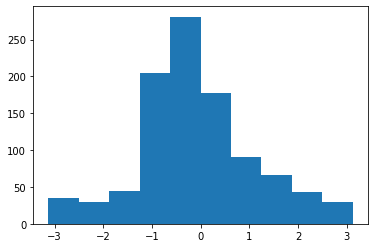

In [10]:
plt.hist(theta_arr )

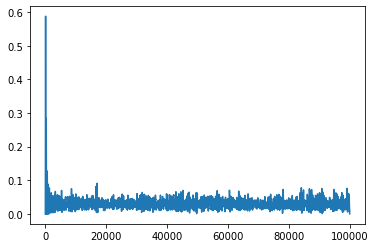

In [11]:
plt.plot(amin_saman_param)

In [12]:
np.mean(amin_saman_param[-100:])

0.017032988933337